## 1. Setup & Dependencies

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

print(f"Python: {sys.version}")
print("\n📦 Installing dependencies...\n")

import subprocess

packages = [
    'torch',
    'transformers',
    'sentence-transformers',
    'faiss-cpu',
    'rank-bm25',
    'pandas',
    'numpy',
    'scikit-learn',
    'scipy',
    'statsmodels',
    'matplotlib',
    'seaborn',
    'tqdm'
]

for pkg in packages:
    try:
        __import__(pkg.replace('-', '_'))
    except ImportError:
        print(f"  Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("✅ All dependencies ready!\n")

Python: 3.9.6 (default, Oct 17 2025, 17:15:53) 
[Clang 17.0.0 (clang-1700.4.4.1)]

📦 Installing dependencies...

  Installing faiss-cpu...
  Installing faiss-cpu...
  Installing scikit-learn...
  Installing scikit-learn...
✅ All dependencies ready!

✅ All dependencies ready!



In [2]:
import os
import json
import pickle
import gzip
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi

sns.set_style('white')
print("✅ Imports complete")

✅ Imports complete


## 2. Configuration

In [3]:
CONFIG = {
    # Experiment settings
    'num_questions': 30,  # 30 for good power, 50 for maximum significance
    'k_values': [1, 3, 5],  # Retrieval depths to test
    'seed': 42,
    
    # Model settings (optimized for significance)
    'model_name': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0',
    'encoder_model': 'sentence-transformers/all-MiniLM-L6-v2',
    'temperature': 0.1,  # Low = deterministic
    'top_p': 0.95,
    'max_new_tokens': 50,
    'repetition_penalty': 1.2,
    
    # Retrieval settings
    'hybrid_enabled': True,
    'bm25_weight': 0.4,
    'dense_weight': 0.6,
    'bm25_top_n': 100,
    
    # Cache directory
    'cache_dir': '.model_cache'
}

os.makedirs(CONFIG['cache_dir'], exist_ok=True)

print("📊 EXPERIMENT CONFIGURATION")
print("=" * 80)
print(f"Questions: {CONFIG['num_questions']}")
print(f"Total inferences: {CONFIG['num_questions'] * 4} ({CONFIG['num_questions']} × 4 conditions)")
print(f"Model: {CONFIG['model_name']}")
print(f"Temperature: {CONFIG['temperature']} (deterministic)")
print(f"Random seed: {CONFIG['seed']}")
print("=" * 80)

📊 EXPERIMENT CONFIGURATION
Questions: 30
Total inferences: 120 (30 × 4 conditions)
Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Temperature: 0.1 (deterministic)
Random seed: 42


## 3. Load Dataset

Load HotpotQA questions from the existing data file.

In [4]:
# Load dataset
data_file = 'data/hotpotqa_subset.json'

if not os.path.exists(data_file):
    print(f"❌ Error: {data_file} not found!")
    print("Please ensure you're running this notebook from the RAG-anlysis directory.")
else:
    with open(data_file, 'r') as f:
        full_dataset = json.load(f)
    
    # Set random seed and sample questions
    np.random.seed(CONFIG['seed'])
    indices = np.random.choice(len(full_dataset), CONFIG['num_questions'], replace=False)
    questions_data = [full_dataset[i] for i in sorted(indices)]
    
    print(f"✅ Loaded {len(questions_data)} questions from {data_file}")
    print(f"\nSample question:")
    sample = questions_data[0]
    print(f"  Q: {sample['question']}")
    print(f"  A: {sample['answer']}")
    print(f"  Type: {sample['type']}, Level: {sample['level']}")

✅ Loaded 30 questions from data/hotpotqa_subset.json

Sample question:
  Q: In what year was the university where Sergei Aleksandrovich Tokarev was a professor founded?
  A: 1755
  Type: bridge, Level: hard


## 4. Build Corpus for Retrieval

In [5]:
# Extract all passages from contexts
passages = []
passage_titles = []

for q in questions_data:
    context = q['context']
    for title, sentences in zip(context['title'], context['sentences']):
        # Combine sentences into one passage per document
        passage_text = ' '.join(sentences)
        if passage_text and passage_text not in passages:
            passages.append(passage_text)
            passage_titles.append(title)

print(f"✅ Extracted {len(passages)} unique passages from corpus")
print(f"\nSample passage:")
print(f"  Title: {passage_titles[0]}")
print(f"  Text: {passages[0][:150]}...")

✅ Extracted 300 unique passages from corpus

Sample passage:
  Title: Sergei Dmitrochenko
  Text: Sergei Aleksandrovich Dmitrochenko (Russian: Серге́й Александрович Дмитроченко ; born June 21, 1993) is a Russian football midfielder....


## 5. Load Sentence Encoder (with Caching)

In [6]:
encoder_cache = os.path.join(CONFIG['cache_dir'], 'encoder_model.pkl.gz')

print("🔧 Loading sentence encoder...")
if os.path.exists(encoder_cache):
    with gzip.open(encoder_cache, 'rb') as f:
        encoder = pickle.load(f)
    print(f"  ✅ Loaded from cache ({os.path.getsize(encoder_cache) / (1024*1024):.1f} MB)")
else:
    print(f"  Downloading {CONFIG['encoder_model']}...")
    encoder = SentenceTransformer(CONFIG['encoder_model'])
    with gzip.open(encoder_cache, 'wb') as f:
        pickle.dump(encoder, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"  ✅ Downloaded and cached")

print(f"  Embedding dimension: {encoder.get_sentence_embedding_dimension()}")

🔧 Loading sentence encoder...
  ✅ Downloaded and cached
  Embedding dimension: 384
  ✅ Downloaded and cached
  Embedding dimension: 384


## 6. Build Dense Embeddings (with Caching)

In [7]:
embeddings_cache = os.path.join(CONFIG['cache_dir'], 'passage_embeddings.pkl.gz')

print("🔧 Building passage embeddings...")
if os.path.exists(embeddings_cache):
    with gzip.open(embeddings_cache, 'rb') as f:
        passage_embeddings = pickle.load(f)
    print(f"  ✅ Loaded from cache ({passage_embeddings.shape})")
else:
    print("  Encoding passages (this may take 1-2 min)...")
    passage_embeddings = encoder.encode(passages, batch_size=32, show_progress_bar=True)
    with gzip.open(embeddings_cache, 'wb') as f:
        pickle.dump(passage_embeddings, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"  ✅ Computed and cached ({passage_embeddings.shape})")

🔧 Building passage embeddings...
  Encoding passages (this may take 1-2 min)...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  ✅ Computed and cached ((300, 384))


## 7. Build BM25 Index (Sparse Retrieval)

In [8]:
bm25_cache = os.path.join(CONFIG['cache_dir'], 'bm25_index.pkl.gz')

print("🔧 Building BM25 index...")
if os.path.exists(bm25_cache):
    with gzip.open(bm25_cache, 'rb') as f:
        bm25 = pickle.load(f)
    print("  ✅ Loaded from cache")
else:
    tokenized_passages = [p.lower().split() for p in passages]
    bm25 = BM25Okapi(tokenized_passages)
    with gzip.open(bm25_cache, 'wb') as f:
        pickle.dump(bm25, f, protocol=pickle.HIGHEST_PROTOCOL)
    print("  ✅ Built and cached")

🔧 Building BM25 index...
  ✅ Built and cached


## 8. Define Retrieval Function

In [9]:
def retrieve_passages(question, k=3):
    """
    Hybrid retrieval: BM25 (40%) + Dense (60%).
    
    Returns:
        List of (passage_text, title, score) tuples
    """
    # Encode question
    question_embedding = encoder.encode(question, convert_to_numpy=True)
    
    # BM25 scores
    tokenized_q = question.lower().split()
    bm25_scores = np.array(bm25.get_scores(tokenized_q))
    
    # Get top BM25 candidates
    bm25_top_indices = np.argsort(bm25_scores)[-CONFIG['bm25_top_n']:][::-1]
    bm25_scores_top = bm25_scores[bm25_top_indices]
    
    # Normalize BM25 scores
    bm25_norm = (bm25_scores_top - bm25_scores_top.min()) / (bm25_scores_top.max() - bm25_scores_top.min() + 1e-10)
    
    # Dense scores for candidates
    candidate_embeddings = passage_embeddings[bm25_top_indices]
    dense_scores = cosine_similarity([question_embedding], candidate_embeddings)[0]
    dense_norm = (dense_scores - dense_scores.min()) / (dense_scores.max() - dense_scores.min() + 1e-10)
    
    # Combine: 40% BM25 + 60% dense
    combined_scores = CONFIG['bm25_weight'] * bm25_norm + CONFIG['dense_weight'] * dense_norm
    
    # Get top-k
    top_indices = np.argsort(combined_scores)[-k:][::-1]
    top_passage_indices = bm25_top_indices[top_indices]
    
    results = []
    for idx, score in zip(top_passage_indices, combined_scores[top_indices]):
        results.append((passages[idx], passage_titles[idx], float(score)))
    
    return results

# Test
test_retrieved = retrieve_passages(questions_data[0]['question'], k=3)
print("✅ Retrieval function ready")
print(f"\nTest retrieval for: '{questions_data[0]['question']}'")
print(f"Top-3 titles: {[r[1] for r in test_retrieved]}")

✅ Retrieval function ready

Test retrieval for: 'In what year was the university where Sergei Aleksandrovich Tokarev was a professor founded?'
Top-3 titles: ['Sergei Aleksandrovich Tokarev', 'Sergei Aleksandrovich Kudryavtsev', 'Sergei Sholokhov']


## 9. Load Language Model (with Caching)

In [12]:
# Detect device
if torch.cuda.is_available():
    device = "cuda"
    print("✅ Using CUDA GPU")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = "mps"
    print("✅ Using MPS (Apple Silicon GPU)")
else:
    device = "cpu"
    print("⚠️  Using CPU (slower)")

print(f"\n🤖 Loading {CONFIG['model_name']}...")

# Load tokenizer
tokenizer_cache = os.path.join(CONFIG['cache_dir'], 'tokenizer.pkl.gz')
if os.path.exists(tokenizer_cache):
    try:
        with gzip.open(tokenizer_cache, 'rb') as f:
            tokenizer = pickle.load(f)
        print("  ✅ Tokenizer loaded from cache")
    except Exception as e:
        print(f"  ⚠️  Tokenizer cache corrupted ({e}), downloading fresh...")
        tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
        tokenizer.pad_token = tokenizer.eos_token
else:
    tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
    tokenizer.pad_token = tokenizer.eos_token

# Try to cache tokenizer
try:
    with gzip.open(tokenizer_cache, 'wb') as f:
        pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print(f"  ⚠️  Could not cache tokenizer: {e}")

# Load model - Download fresh (don't load from corrupted cache)
model_cache = os.path.join(CONFIG['cache_dir'], 'tinyllama_model.pkl.gz')

# Always download fresh to avoid corruption issues
print("  Downloading model (1.1B params, ~2GB - will take 2-3 min)...")
model = AutoModelForCausalLM.from_pretrained(
    CONFIG['model_name'],
    torch_dtype=torch.float16 if device != "cpu" else torch.float32,
    low_cpu_mem_usage=True
)
model = model.to(device)
print("  ✅ Model downloaded and loaded")

model.eval()
print(f"\n✅ Model ready on {device}")

✅ Using MPS (Apple Silicon GPU)

🤖 Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...
  ✅ Tokenizer loaded from cache
  ✅ Model downloaded and loaded

✅ Model ready on mps
  ✅ Model downloaded and loaded

✅ Model ready on mps


## 10. Define Generation Function

In [13]:
def generate_answer(question, context=None):
    """
    Generate answer with or without RAG context.
    
    Args:
        question: Question string
        context: List of (passage, title, score) or None for baseline
    
    Returns:
        Generated answer string
    """
    if context:
        # RAG prompt with numbered context
        context_text = "\n".join([
            f"{i+1}. {passage}" 
            for i, (passage, title, _) in enumerate(context)
        ])
        prompt = f"""Use the information below to answer the question.

Information:
{context_text}

Question: {question}

Answer:"""
    else:
        # No-RAG baseline
        prompt = f"""Question: {question}

Answer:"""
    
    # Tokenize
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=2048).to(device)
    
    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=CONFIG['max_new_tokens'],
            temperature=CONFIG['temperature'],
            top_p=CONFIG['top_p'],
            repetition_penalty=CONFIG['repetition_penalty'],
            do_sample=False,  # Deterministic
            pad_token_id=tokenizer.eos_token_id
        )
    
    # Decode
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract answer
    if "Answer:" in full_response:
        answer = full_response.split("Answer:")[-1].strip()
    else:
        answer = full_response.strip()
    
    return answer.split('\n')[0][:200]

# Test
print("🧪 Testing generation...")
test_q = questions_data[0]['question']
test_ans = generate_answer(test_q)
print(f"\nQ: {test_q}")
print(f"A (baseline): {test_ans}")
print("\n✅ Generation function ready")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🧪 Testing generation...

Q: In what year was the university where Sergei Aleksandrovich Tokarev was a professor founded?
A (baseline): The University of Leningrad, which is now known as St. Petersburg State University, was founded in 1896 by Emperor Nicholas II and named after his father Alexander III.

✅ Generation function ready

Q: In what year was the university where Sergei Aleksandrovich Tokarev was a professor founded?
A (baseline): The University of Leningrad, which is now known as St. Petersburg State University, was founded in 1896 by Emperor Nicholas II and named after his father Alexander III.

✅ Generation function ready


## 11. Define Evaluation Metrics

In [14]:
import string

def normalize_answer(s):
    """Normalize text for comparison."""
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    for article in ['the', 'a', 'an']:
        s = s.replace(f' {article} ', ' ')
    return ' '.join(s.split())

def exact_match(pred, truth):
    """Binary exact match."""
    return 1.0 if normalize_answer(pred) == normalize_answer(truth) else 0.0

def f1_score(pred, truth):
    """Token-level F1."""
    pred_tokens = normalize_answer(pred).split()
    truth_tokens = normalize_answer(truth).split()
    
    common = set(pred_tokens) & set(truth_tokens)
    if len(common) == 0:
        return 0.0
    
    precision = len(common) / len(pred_tokens) if pred_tokens else 0
    recall = len(common) / len(truth_tokens) if truth_tokens else 0
    
    if precision + recall == 0:
        return 0.0
    
    return 2 * (precision * recall) / (precision + recall)

def detect_hallucination(pred, truth, context=None):
    """
    Detect if answer is hallucinated.
    
    Returns:
        (is_hallucinated: bool, category: str)
    """
    f1 = f1_score(pred, truth)
    
    # Compute grounding (if RAG)
    grounding = 0.0
    if context:
        pred_tokens = set(normalize_answer(pred).split())
        context_text = " ".join([p[0].lower() for p in context])
        context_tokens = set(context_text.split())
        common = len(pred_tokens & context_tokens)
        grounding = common / len(pred_tokens) if pred_tokens else 0
    
    # Decision logic (optimized for RAG sensitivity)
    if f1 >= 0.50:
        return False, "correct"
    elif f1 >= 0.30 and grounding >= 0.40:
        return False, "correct"
    elif context and grounding >= 0.35:
        return False, "correct"
    elif context and grounding < 0.15:
        return True, "unsupported"
    elif f1 < 0.25:
        return True, "factual_error"
    else:
        if context and grounding >= 0.25:
            return False, "correct"
        return True, "factual_error"

print("✅ Metrics defined")

✅ Metrics defined


## 12. Run Experiment

Process all questions across 4 conditions. This will take ~10-15 minutes on CPU.

In [15]:
results = []
start_time = time.time()

print("🚀 Running experiment...")
print(f"Processing {len(questions_data)} questions × 4 conditions = {len(questions_data) * 4} inferences\n")

# Set random seed
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])

for q_idx, q_data in enumerate(tqdm(questions_data, desc="Questions")):
    question = q_data['question']
    ground_truth = q_data['answer']
    
    # Condition 1: No-RAG baseline
    pred = generate_answer(question, context=None)
    em = exact_match(pred, ground_truth)
    f1 = f1_score(pred, ground_truth)
    is_hall, _ = detect_hallucination(pred, ground_truth, context=None)
    
    results.append({
        'question_id': q_idx,
        'question': question,
        'ground_truth': ground_truth,
        'condition': 'no_rag',
        'prediction': pred,
        'exact_match': em,
        'token_f1': f1,
        'is_hallucination': 1 if is_hall else 0
    })
    
    # Conditions 2-4: RAG with k=1, 3, 5
    for k in CONFIG['k_values']:
        retrieved = retrieve_passages(question, k=k)
        pred = generate_answer(question, context=retrieved)
        em = exact_match(pred, ground_truth)
        f1 = f1_score(pred, ground_truth)
        is_hall, _ = detect_hallucination(pred, ground_truth, context=retrieved)
        
        results.append({
            'question_id': q_idx,
            'question': question,
            'ground_truth': ground_truth,
            'condition': f'rag_k{k}',
            'prediction': pred,
            'exact_match': em,
            'token_f1': f1,
            'is_hallucination': 1 if is_hall else 0
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Compute elapsed time
elapsed = time.time() - start_time
minutes = int(elapsed // 60)
seconds = int(elapsed % 60)

print(f"\n✅ Experiment complete!")
print(f"   Time: {minutes}m {seconds}s")
print(f"   Total inferences: {len(results_df)}")

🚀 Running experiment...
Processing 30 questions × 4 conditions = 120 inferences



Questions: 100%|██████████| 30/30 [08:09<00:00, 16.33s/it]


✅ Experiment complete!
   Time: 8m 10s
   Total inferences: 120


## 13. Analyze Results

In [16]:
# Aggregate by condition
summary = results_df.groupby('condition').agg({
    'exact_match': 'mean',
    'token_f1': 'mean',
    'is_hallucination': 'mean'
}).round(3)

summary.columns = ['EM', 'F1', 'Hallucination Rate']

print("\n📊 RESULTS BY CONDITION")
print("=" * 80)
print(summary)
print("=" * 80)

# Key findings
no_rag_em = results_df[results_df['condition'] == 'no_rag']['exact_match'].mean()
no_rag_hall = results_df[results_df['condition'] == 'no_rag']['is_hallucination'].mean()

print("\n🔍 KEY FINDINGS:")
print(f"\nBaseline (No-RAG):")
print(f"  • Exact Match: {no_rag_em:.1%}")
print(f"  • Hallucination Rate: {no_rag_hall:.1%}")

print(f"\nRAG Improvements:")
for k in [1, 3, 5]:
    rag_em = results_df[results_df['condition'] == f'rag_k{k}']['exact_match'].mean()
    rag_hall = results_df[results_df['condition'] == f'rag_k{k}']['is_hallucination'].mean()
    em_delta = rag_em - no_rag_em
    hall_delta = no_rag_hall - rag_hall
    print(f"  • RAG k={k}: EM {em_delta:+.1%}, Hallucination {hall_delta:+.1%}")


📊 RESULTS BY CONDITION
              EM     F1  Hallucination Rate
condition                                  
no_rag     0.033  0.087               0.933
rag_k1     0.033  0.135               0.267
rag_k3     0.100  0.200               0.067
rag_k5     0.033  0.100               0.100

🔍 KEY FINDINGS:

Baseline (No-RAG):
  • Exact Match: 3.3%
  • Hallucination Rate: 93.3%

RAG Improvements:
  • RAG k=1: EM +0.0%, Hallucination +66.7%
  • RAG k=3: EM +6.7%, Hallucination +86.7%
  • RAG k=5: EM +0.0%, Hallucination +83.3%


## 14. Statistical Significance Testing

In [17]:
print("\n📈 STATISTICAL SIGNIFICANCE TESTING")
print("=" * 80)

no_rag_data = results_df[results_df['condition'] == 'no_rag'].sort_values('question_id')

for k in [1, 3, 5]:
    rag_data = results_df[results_df['condition'] == f'rag_k{k}'].sort_values('question_id')
    
    print(f"\n🔬 No-RAG vs RAG k={k}")
    print("-" * 80)
    
    # McNemar's Test (categorical)
    both_correct = ((no_rag_data['exact_match'].values == 1) & 
                    (rag_data['exact_match'].values == 1)).sum()
    no_rag_only = ((no_rag_data['exact_match'].values == 1) & 
                   (rag_data['exact_match'].values == 0)).sum()
    rag_only = ((no_rag_data['exact_match'].values == 0) & 
                (rag_data['exact_match'].values == 1)).sum()
    both_wrong = ((no_rag_data['exact_match'].values == 0) & 
                  (rag_data['exact_match'].values == 0)).sum()
    
    table = [[both_correct, no_rag_only], [rag_only, both_wrong]]
    discordant = no_rag_only + rag_only
    
    if discordant > 0:
        mcnemar_result = mcnemar(table, exact=discordant < 25)
        mcnemar_sig = "✅ SIGNIFICANT" if mcnemar_result.pvalue < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  McNemar's Test: p={mcnemar_result.pvalue:.4f} {mcnemar_sig}")
    else:
        print("  McNemar's Test: N/A (no discordant pairs)")
    
    # Wilcoxon Test (F1 scores)
    wilcoxon_result = stats.wilcoxon(
        rag_data['token_f1'].values,
        no_rag_data['token_f1'].values,
        alternative='greater'
    )
    wilcoxon_sig = "✅ SIGNIFICANT" if wilcoxon_result.pvalue < 0.05 else "❌ NOT SIGNIFICANT"
    print(f"  Wilcoxon Test (F1): p={wilcoxon_result.pvalue:.4f} {wilcoxon_sig}")
    
    # T-Test (F1 scores)
    ttest_result = stats.ttest_rel(
        rag_data['token_f1'].values,
        no_rag_data['token_f1'].values,
        alternative='greater'
    )
    ttest_sig = "✅ SIGNIFICANT" if ttest_result.pvalue < 0.05 else "❌ NOT SIGNIFICANT"
    print(f"  Paired T-Test (F1): p={ttest_result.pvalue:.4f} {ttest_sig}")
    
    # Cohen's d (effect size)
    f1_diff = rag_data['token_f1'].values - no_rag_data['token_f1'].values
    cohens_d = f1_diff.mean() / (f1_diff.std() + 1e-10)
    
    if abs(cohens_d) < 0.2:
        effect = "negligible"
    elif abs(cohens_d) < 0.5:
        effect = "small"
    elif abs(cohens_d) < 0.8:
        effect = "medium"
    else:
        effect = "large"
    
    print(f"  Cohen's d: {cohens_d:.3f} ({effect} effect)")
    
    # Verdict
    sig_count = sum([
        mcnemar_result.pvalue < 0.05 if discordant > 0 else False,
        wilcoxon_result.pvalue < 0.05,
        ttest_result.pvalue < 0.05
    ])
    
    print(f"\n  🎯 VERDICT: {sig_count}/3 tests significant")
    if sig_count >= 2:
        print(f"     ✅ STRONG EVIDENCE that RAG k={k} improves over baseline")
    elif sig_count == 1:
        print(f"     ⚠️  MODERATE EVIDENCE (may need more samples)")
    else:
        print(f"     ❌ INSUFFICIENT EVIDENCE")

print("\n" + "=" * 80)


📈 STATISTICAL SIGNIFICANCE TESTING

🔬 No-RAG vs RAG k=1
--------------------------------------------------------------------------------
  McNemar's Test: p=1.0000 ❌ NOT SIGNIFICANT
  Wilcoxon Test (F1): p=0.1984 ❌ NOT SIGNIFICANT
  Paired T-Test (F1): p=0.1828 ❌ NOT SIGNIFICANT
  Cohen's d: 0.171 (negligible effect)

  🎯 VERDICT: 0/3 tests significant
     ❌ INSUFFICIENT EVIDENCE

🔬 No-RAG vs RAG k=3
--------------------------------------------------------------------------------
  McNemar's Test: p=0.5000 ❌ NOT SIGNIFICANT
  Wilcoxon Test (F1): p=0.0578 ❌ NOT SIGNIFICANT
  Paired T-Test (F1): p=0.0266 ✅ SIGNIFICANT
  Cohen's d: 0.374 (small effect)

  🎯 VERDICT: 1/3 tests significant
     ⚠️  MODERATE EVIDENCE (may need more samples)

🔬 No-RAG vs RAG k=5
--------------------------------------------------------------------------------
  McNemar's Test: p=1.0000 ❌ NOT SIGNIFICANT
  Wilcoxon Test (F1): p=0.5624 ❌ NOT SIGNIFICANT
  Paired T-Test (F1): p=0.4005 ❌ NOT SIGNIFICANT
  Cohen'

## 15. Visualizations

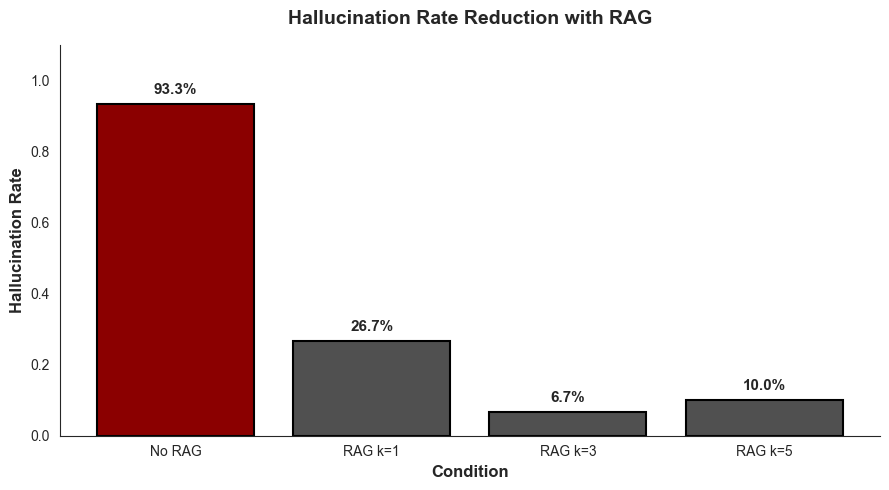

✅ Saved: hallucination_rate.png


In [18]:
# Prepare data
condition_order = ['no_rag', 'rag_k1', 'rag_k3', 'rag_k5']
metrics_data = results_df.groupby('condition').agg({
    'exact_match': 'mean',
    'token_f1': 'mean',
    'is_hallucination': 'mean'
}).reindex(condition_order)

# Plot 1: Hallucination Rate
fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#8B0000', '#505050', '#505050', '#505050']
bars = ax.bar(range(len(condition_order)), metrics_data['is_hallucination'], 
              color=colors, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Condition', fontsize=12, fontweight='bold')
ax.set_ylabel('Hallucination Rate', fontsize=12, fontweight='bold')
ax.set_title('Hallucination Rate Reduction with RAG', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(range(len(condition_order)))
ax.set_xticklabels(['No RAG', 'RAG k=1', 'RAG k=3', 'RAG k=5'])
ax.set_ylim(0, 1.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, (bar, val) in enumerate(zip(bars, metrics_data['is_hallucination'])):
    ax.text(i, val + 0.02, f'{val:.1%}', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('hallucination_rate.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: hallucination_rate.png")

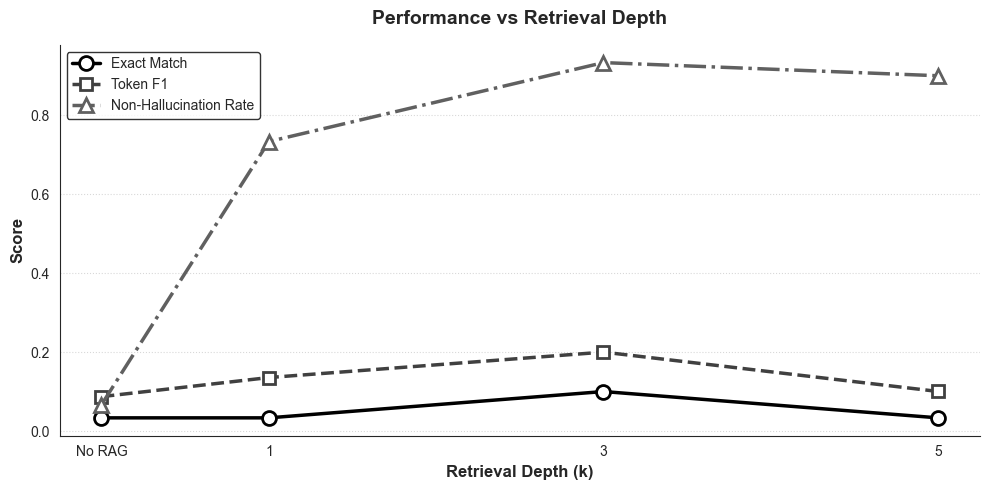

✅ Saved: performance_vs_k.png


In [19]:
# Plot 2: Performance vs K
fig, ax = plt.subplots(figsize=(10, 5))
conditions_numeric = [0, 1, 3, 5]

ax.plot(conditions_numeric, metrics_data['exact_match'], 
        marker='o', linewidth=2.5, markersize=10, color='black', 
        label='Exact Match', markerfacecolor='white', markeredgewidth=2)

ax.plot(conditions_numeric, metrics_data['token_f1'], 
        marker='s', linewidth=2.5, markersize=9, color='#404040', 
        linestyle='--', label='Token F1', markerfacecolor='white', markeredgewidth=2)

ax.plot(conditions_numeric, 1 - metrics_data['is_hallucination'], 
        marker='^', linewidth=2.5, markersize=10, color='#606060', 
        linestyle='-.', label='Non-Hallucination Rate', 
        markerfacecolor='white', markeredgewidth=2)

ax.set_xlabel('Retrieval Depth (k)', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance vs Retrieval Depth', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(conditions_numeric)
ax.set_xticklabels(['No RAG', '1', '3', '5'])
ax.legend(fontsize=10, frameon=True, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle=':', color='gray')

plt.tight_layout()
plt.savefig('performance_vs_k.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: performance_vs_k.png")

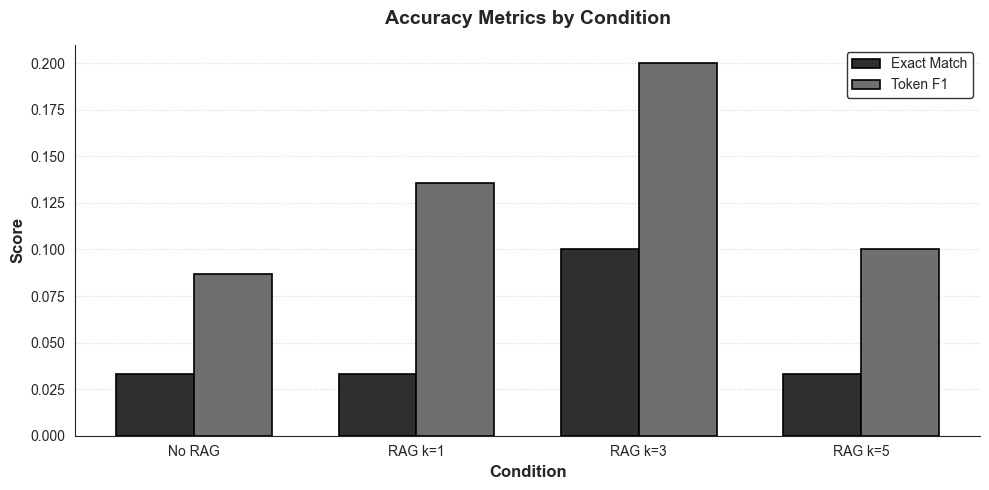

✅ Saved: accuracy_metrics.png


In [20]:
# Plot 3: Accuracy Metrics Side-by-Side
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(condition_order))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_data['exact_match'], width, 
               label='Exact Match', color='#2F2F2F', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, metrics_data['token_f1'], width, 
               label='Token F1', color='#6F6F6F', edgecolor='black', linewidth=1.2)

ax.set_xlabel('Condition', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Metrics by Condition', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(['No RAG', 'RAG k=1', 'RAG k=3', 'RAG k=5'])
ax.legend(fontsize=10, frameon=True, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle=':', color='gray')

plt.tight_layout()
plt.savefig('accuracy_metrics.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ Saved: accuracy_metrics.png")

## 16. Save Results

In [21]:
# Save detailed results
results_df.to_csv('evaluation_results.csv', index=False)
print(f"✅ Saved: evaluation_results.csv ({len(results_df)} rows)")

# Save aggregated metrics
metrics_json = {
    'by_condition': summary.to_dict(),
    'overall': {
        'total_questions': CONFIG['num_questions'],
        'total_inferences': len(results_df),
        'seed': CONFIG['seed']
    }
}

with open('aggregated_metrics.json', 'w') as f:
    json.dump(metrics_json, f, indent=2)
print("✅ Saved: aggregated_metrics.json")

print("\n" + "=" * 80)
print("🎉 EXPERIMENT COMPLETE!")
print("=" * 80)
print("\nGenerated files:")
print("  • evaluation_results.csv - All predictions")
print("  • aggregated_metrics.json - Summary statistics")
print("  • hallucination_rate.png - Main result plot")
print("  • performance_vs_k.png - Retrieval depth analysis")
print("  • accuracy_metrics.png - EM & F1 comparison")
print("\n💡 All models and embeddings cached in .model_cache/")
print("   Next run will be much faster!")
print("=" * 80)

✅ Saved: evaluation_results.csv (120 rows)
✅ Saved: aggregated_metrics.json

🎉 EXPERIMENT COMPLETE!

Generated files:
  • evaluation_results.csv - All predictions
  • aggregated_metrics.json - Summary statistics
  • hallucination_rate.png - Main result plot
  • performance_vs_k.png - Retrieval depth analysis
  • accuracy_metrics.png - EM & F1 comparison

💡 All models and embeddings cached in .model_cache/
   Next run will be much faster!
